In [1]:
%matplotlib inline

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt
import pickle
# from keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout, Activation, Flatten, Lambda
from tensorflow.keras.layers import BatchNormalization, AveragePooling2D
from tensorflow.keras.optimizers import SGD, Adadelta, Adagrad, Adam, RMSprop
from tensorflow import keras
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules
from tensorflow.keras.layers import Convolution2D, MaxPooling2D
# from tensorflow.keras.optimizers.schedules import CosineDecayRestarts
import numpy as np
from PIL import Image
# import theano
# from theano import tensor as T
import os
from sklearn.model_selection import train_test_split
# from tensorflow.keras.utils import np_utils, generic_utils
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.preprocessing.image
from sklearn.model_selection import KFold, StratifiedKFold
from collections import Counter
from skimage.transform import rescale, resize
import wandb
from wandb.keras import WandbCallback
from sklearn.metrics import confusion_matrix
from scikitplot.metrics import plot_confusion_matrix, plot_roc

/mnt/tank/scratch/nkhanzhina/miniconda3/envs/env-tf23/lib/python3.7/site-packages/tensorflow_addons/utils/ensure_tf_install.py:68: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.1.0 and strictly below 2.3.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.3.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


In [4]:
import tensorflow as tf
tf.__version__

'2.1.0'

In [3]:
wandb.login()

wandb: Currently logged in as: natkaha (use `wandb login --relogin` to force relogin)


True

In [181]:
import tensorflow as tf
os.environ['CUDA_VISIBLE_DEVICES'] = str(0)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
tf.keras.backend.set_session(tf.Session(config=config))

AttributeError: module 'tensorflow' has no attribute 'ConfigProto'

In [5]:
import tensorflow as tf
gpu_id = '0'
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only use the first GPU.
    try:
        # Currently, memory growth needs to be the same across GPUs.
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        tf.config.experimental.set_visible_devices(gpus[int(gpu_id)], 'GPU')
    except RuntimeError as e:
    # Visible devices must be set before GPUs have been initialized.
        print('!!!!!!!!!!',e)    

In [4]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')]

In [22]:
def change_range(img):
    OldMin = 0
    OldMax = 255
    NewMin = -1
    NewMax = 1
#     print(img.shape)
    OldRange = (OldMax - OldMin)
    NewRange = (NewMax - NewMin)
    new_img = ((((img - OldMin) * NewRange) / OldRange) + NewMin)
    return np.asarray(new_img, dtype='int8')

In [23]:
dataset_dir = u"./cropped_pollen_bayesian"
nb_classes = 0
pollen_real = []
target_real = []
for d, dirs, files in os.walk(dataset_dir):
#     print(d.split(os.path.sep)[-1])
    nb_classes += 1
    images = filter(lambda x: x.endswith('.png'), files)     
    for f in images: 
        path = os.path.join(d,f)
        img = Image.open(path)
        img = np.asarray(img, dtype='uint8')
        img = resize(img, (32, 32),
                     preserve_range=True,
                       anti_aliasing=True) 
        img = change_range(img)
        pollen_real.append(img)
        target_real.append(d.split(os.path.sep)[-1])      
pollen_real = np.array(pollen_real) 
target_real = np.array(target_real)
nb_classes -= 1 
counter = Counter(np.array(target_real))
print(counter)

Counter({'maple': 1149, 'willow': 815, 'birch': 657, 'alder': 468, 'linden': 337, 'pigweed': 317, 'sorrel': 271, 'nettle': 231, 'pine': 230, 'plantain': 217, 'grass': 213, 'mugwort': 118, 'hazel': 77})


In [25]:
pollen_real[0,:,:,:].min()

0

In [174]:
cats = np.unique(target_real)
di = dict(zip(cats,np.arange(len(cats))))

In [175]:
di

{'alder': 0,
 'birch': 1,
 'grass': 2,
 'hazel': 3,
 'linden': 4,
 'maple': 5,
 'mugwort': 6,
 'nettle': 7,
 'pigweed': 8,
 'pine': 9,
 'plantain': 10,
 'sorrel': 11,
 'willow': 12}

In [176]:
pollen_X_train, pollen_X_val, pollen_y_train, pollen_y_val = train_test_split(pollen_real, target_real, test_size=0.15, random_state=23)
print(nb_classes)
target_new = []
for item in pollen_y_val:
    target_new.append(di[item])
pollen_y_val = target_new
pollen_y_val = np.array(pollen_y_val)
pollen_Y_val = to_categorical(pollen_y_val, nb_classes)

13


In [75]:
counter = Counter(pollen_y_val)
print(counter)

Counter({5: 158, 12: 129, 1: 111, 0: 83, 4: 53, 8: 41, 7: 37, 11: 36, 10: 33, 9: 31, 2: 24, 6: 20, 3: 9})


In [177]:
pollen = pollen_X_train
target = pollen_y_train

In [107]:
# dataset_dir = u"./SELF_ATTENTION_GET_65k"
dataset_dir = u"./STYLE_GAN_GEN_65k"
# nb_classes = 0
pollen_gan = []
target_gan = []
for d, dirs, files in os.walk(dataset_dir):
#     nb_classes += 1
    images = filter(lambda x: x.endswith('.jpeg'), files)     
    num = sum(1 for _ in filter(lambda x: x.endswith('.jpeg'), files))
    for i,f in enumerate(images): 
#         if (i < (num - 500) or num < 500):
        path = os.path.join(d,f)
        img = Image.open(path)
        img = np.asarray(img, dtype='uint8')
        img = resize(img, (32, 32),
                       anti_aliasing=True)        
        pollen_gan.append(img)
        target_gan.append(d.split(os.path.sep)[-1])      
pollen_gan = np.array(pollen_gan) 
target_gan = np.array(target_gan)
# nb_classes -= 1 
counter = Counter(np.array(target_gan))
print(counter)

Counter({'pine': 5000, 'plantain': 5000, 'alder': 5000, 'maple': 5000, 'sorrel': 5000, 'nettle': 5000, 'pigweed': 5000, 'hazel': 5000, 'willow': 5000, 'linden': 5000, 'grass': 5000, 'mugwort': 5000, 'birch': 5000})


In [7]:
pollen = pollen_gan
target = target_gan

In [56]:
pollen_real.shape

(5100, 32, 32, 3)

In [44]:
target_real

array(['birch', 'birch', 'birch', ..., 'sorrel', 'sorrel', 'sorrel'],
      dtype='<U8')

In [43]:
ind = np.where(pollen_y_train=='maple')
# ind = ind[0][600:]
print(len(ind[0]))

991


In [9]:
ind = np.where(pollen_y_train=='willow')
ind = ind[0][400:]
# print(len(ind))
pollen_X_train = np.delete(pollen_X_train,ind, axis=0)
pollen_y_train = np.delete(pollen_y_train,ind, axis=0)

In [10]:
ind = np.where(pollen_y_train=='birch')
ind = ind[0][400:]
# print(len(ind))
pollen_X_train = np.delete(pollen_X_train,ind, axis=0)
pollen_y_train = np.delete(pollen_y_train,ind, axis=0)

In [11]:
ind = np.where(pollen_y_train=='maple')
ind = ind[0][400:]
# print(len(ind))
pollen_X_train = np.delete(pollen_X_train,ind, axis=0)
pollen_y_train = np.delete(pollen_y_train,ind, axis=0)

In [47]:
ind = np.where(target_gan=='willow')
ind = ind[0][200:]
# print(len(ind))
pollen_gan = np.delete(pollen_gan,ind, axis=0)
target_gan = np.delete(target_gan,ind, axis=0)

NameError: name 'target_gan' is not defined

In [ ]:
ind = np.where(target_gan=='birch')
ind = ind[0][200:]
# print(len(ind))
pollen_gan = np.delete(pollen_gan,ind, axis=0)
target_gan = np.delete(target_gan,ind, axis=0)

In [83]:
pollen_X_train.shape

(3858, 32, 32, 3)

In [84]:
pollen_y_train.shape

(3858,)

In [10]:
pollen = []
# target = []
pollen = np.concatenate((pollen_X_train, pollen_gan), axis=0)
target = np.concatenate((pollen_y_train, target_gan), axis=0)
# pollen = np.concatenate((pollen_real, pollen_gan), axis=0)
# target = np.concatenate((target_real, target_gan), axis=0)

In [53]:
counter = Counter(np.array(target))
counter

Counter({'birch': 400,
         'pigweed': 276,
         'alder': 385,
         'maple': 400,
         'hazel': 68,
         'plantain': 184,
         'sorrel': 235,
         'grass': 189,
         'willow': 400,
         'linden': 284,
         'pine': 199,
         'nettle': 194,
         'mugwort': 98})

In [41]:
target

array([ 1,  8,  0, ...,  0,  8, 11])

In [178]:
target_new = []
for item in target:
    target_new.append(di[item])
target = target_new
target = np.array(target)
# target1 = np_utils.to_categorical(target.map(di))

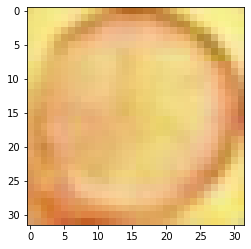

In [55]:
plt.imshow(pollen_gan[1700])
plt.show()

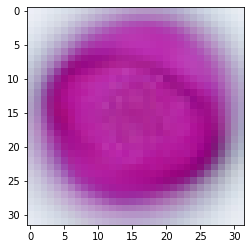

In [56]:
plt.imshow(pollen_real[1700])
plt.show()

In [57]:
pollen_real[target_real==di[target_real[0]]]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [17]:
len(pollen_real)

5100

In [16]:
len(pollen_real[target_real=='birch'])

657

alder
birch
grass
hazel
linden
maple
mugwort
nettle
pigweed
pine
plantain
sorrel
willow


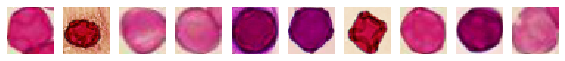

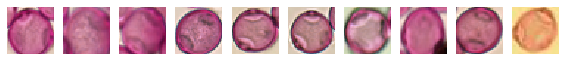

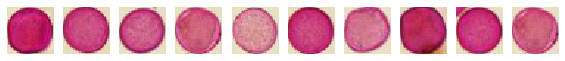

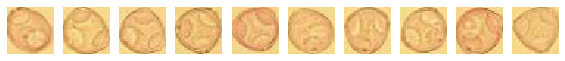

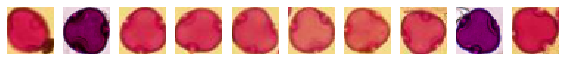

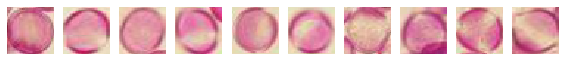

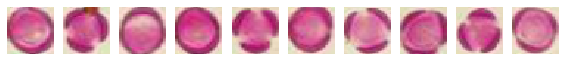

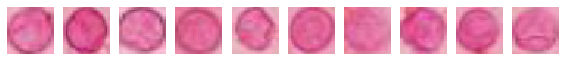

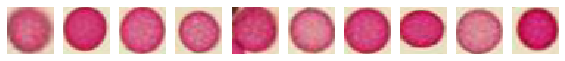

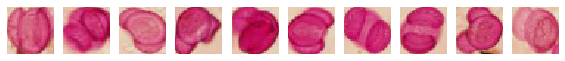

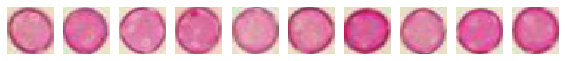

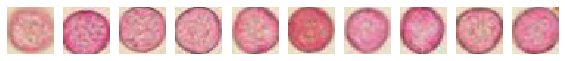

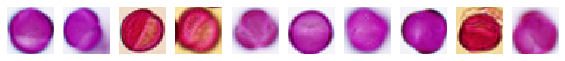

In [130]:
from numpy import random

for key,value in di.items():
    fig = plt.figure(figsize=(32, 32*10))
#     plt.axis('off')
#     fig.axes.get_xaxis().set_visible(False)
#     fig.axes.get_yaxis().set_visible(False)
    print(key)
    for j in range(10):
        ax = fig.add_subplot(32, 32, j + 1)
        ind = random.randint(0, len(pollen_real[target_real==key]))
        ax.imshow(pollen_real[target_real==key][ind], cmap=plt.cm.binary, interpolation='nearest')
        plt.axis('off')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
    plt.savefig('pic/'+key+".png", bbox_inches='tight', pad_inches=0)

In [133]:
english_to_latin = [['willow','Salix'],
['linden','Tilia'],
['alder','Alnus'],
['birch','Betula'],
['nettle','Urtica'],
['pigweed','Chenopodiaceae'],
['plantain','Plantago'],
['sorrel','Rumex'],
['grass','Poaceae'],
['pine','Pinus'],
['maple','Acer'],
['hazel','Corylus'],
['mugwort','Artemisia']]

In [134]:
english_to_latin = np.array(english_to_latin)

In [135]:
english_to_latin = dict(zip(english_to_latin[:,0], english_to_latin[:,1]))

In [136]:
english_to_latin

{'willow': 'Salix',
 'linden': 'Tilia',
 'alder': 'Alnus',
 'birch': 'Betula',
 'nettle': 'Urtica',
 'pigweed': 'Chenopodiaceae',
 'plantain': 'Plantago',
 'sorrel': 'Rumex',
 'grass': 'Poaceae',
 'pine': 'Pinus',
 'maple': 'Acer',
 'hazel': 'Corylus',
 'mugwort': 'Artemisia'}

In [156]:
di

{'alder': 0,
 'birch': 1,
 'grass': 2,
 'hazel': 3,
 'linden': 4,
 'maple': 5,
 'mugwort': 6,
 'nettle': 7,
 'pigweed': 8,
 'pine': 9,
 'plantain': 10,
 'sorrel': 11,
 'willow': 12}

In [155]:
english_to_latin['willow']

'Salix'

In [138]:
english_to_latin.items()

dict_items([('willow', 'Salix'), ('linden', 'Tilia'), ('alder', 'Alnus'), ('birch', 'Betula'), ('nettle', 'Urtica'), ('pigweed', 'Chenopodiaceae'), ('plantain', 'Plantago'), ('sorrel', 'Rumex'), ('grass', 'Poaceae'), ('pine', 'Pinus'), ('maple', 'Acer'), ('hazel', 'Corylus'), ('mugwort', 'Artemisia')])

In [172]:
target

array(['Betula', 'Chenopodiaceae', 'Alnus', ..., 'Salix', 'Rumex',
       'Betula'], dtype='<U14')

In [168]:
key = [k for k, v in di.items() if v == 0]
key

['alder']

In [169]:
target_new = []
for item in target:
    key = [k for k, v in di.items() if v == item]
    target_new.append(english_to_latin[key[0]])
target = target_new
target = np.array(target)
# target1 = np_utils.to_categorical(target.map(di))

In [171]:
target_new = []
for item in target:
    target_new.append(english_to_latin[item])
target = target_new
target = np.array(target)

KeyError: 'Betula'

In [82]:
latin = sorted(english_to_latin.items(), key=lambda item: item[1])

In [92]:
latin

[('maple', 'Acer'),
 ('alder', 'Alnus'),
 ('pigweed', 'Amaranthus'),
 ('mugwort', 'Artemisia'),
 ('birch', 'Betula'),
 ('hazel', 'Corylus'),
 ('pine', 'Pinus'),
 ('plantain', 'Plantago'),
 ('grass', 'Poaceae'),
 ('sorrel', 'Rumex'),
 ('willow', 'Salix'),
 ('linden', 'Tilia'),
 ('nettle', 'Urtica')]

In [97]:
target_real

array(['birch', 'birch', 'birch', ..., 'sorrel', 'sorrel', 'sorrel'],
      dtype='<U8')

## baseline

maple
alder
pigweed
mugwort
birch
hazel
pine
plantain
grass
sorrel
willow
linden
nettle


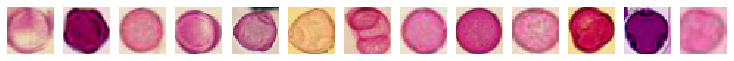

In [129]:
from numpy import random

fig = plt.figure(figsize=(32, 32*13))
# plt.axis('off')
for i,key in enumerate(latin):
#     for j in range(2):
#         ax = fig.add_subplot(32, 32, i*2 + j + 1)
    ax = fig.add_subplot(32, 32, i + 1)
    ind = random.randint(0, len(pollen_real[target_real==key[0]]))
    print(key[0])
    ax.imshow(pollen_real[target_real==key[0]][ind], cmap=plt.cm.binary, interpolation='nearest')
    plt.axis('off')
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
plt.savefig('pic/baseline1.png', bbox_inches='tight', pad_inches=0)

## sagan

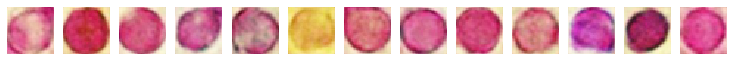

In [106]:
fig = plt.figure(figsize=(32, 32*13))
for i,key in enumerate(latin):
    if any(target_gan==key[0])==True:
        ax = fig.add_subplot(32, 32, i + 1)
        ind = random.randint(0, len(pollen_gan[target_gan==key[0]]))       
        ax.imshow(pollen_gan[target_gan==key[0]][ind], cmap=plt.cm.binary, interpolation='nearest')
        plt.axis('off')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
plt.savefig('pic/sagan.png', bbox_inches='tight', pad_inches=0)        

## stylegan

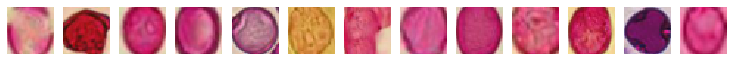

In [128]:
fig = plt.figure(figsize=(32, 32*13))
for i,key in enumerate(latin):
    if any(target_gan==key[0])==True:
        ax = fig.add_subplot(32, 32, i + 1)
        ind = random.randint(0, len(pollen_gan[target_gan==key[0]]))       
        ax.imshow(pollen_gan[target_gan==key[0]][ind], cmap=plt.cm.binary, interpolation='nearest')
        plt.axis('off')
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
plt.savefig('pic/stylegan1.png', bbox_inches='tight', pad_inches=0)          

In [30]:
di

{'alder': 0,
 'birch': 1,
 'grass': 2,
 'hazel': 3,
 'linden': 4,
 'maple': 5,
 'mugwort': 6,
 'nettle': 7,
 'pigweed': 8,
 'pine': 9,
 'plantain': 10,
 'sorrel': 11,
 'willow': 12}

In [43]:
import warnings
warnings.filterwarnings('ignore')

In [44]:
pollen_X_val.max()

1.0

In [19]:
suffix = '_sagan_65k_deep_'
# stage = "baseline_"
# stage = "fine_tuning"
stage = "transfer_learning"
batch_size = 32
nb_epoch = 300
learning_rate = 1e-2
optimizer =  Adam(lr=learning_rate)
data_augmentation = True
# number of convolutional filters to use at each layer
# nb_filters = [16, 32, 64]
nb_filters = [64, 64, 64, 64, 64, 64]
# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [2, 2]
# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [3, 3, 3, 3, 3, 3]
# input image dimensions
img_rows, img_cols = pollen.shape[1],pollen.shape[2]
print(img_rows,img_cols)
img_channels = 3
means_sc = []
means_ac = []
means_f1 = []
means_ac_val = []
means_f1_val = []


cv=0
kf = StratifiedKFold(n_splits=5)
for train, test in kf.split(pollen, target):
# for i in range(1):
    print("!-----------------------"+str(cv+1)+"--------------------------!")

    datagen = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

    inputs = Input(shape=(img_rows, img_cols, img_channels))
    
    for i in range(5):
        if i==0:
            x = Convolution2D(nb_filters[i], (nb_conv[i], nb_conv[i]), padding='same')(inputs)
        else:
            x = Convolution2D(nb_filters[i], (nb_conv[i], nb_conv[i]), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = AveragePooling2D(pool_size=(2, 2))(x)
        
    x = Flatten()(x)
    x = Dense(30)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes)(x)
    outputs = Activation('softmax')(x)
    model = keras.Model(inputs, outputs)
    
    if stage == "fine_tuning":
        initial_learning_rate = 1e-3
    else:    
        initial_learning_rate = 1e-2    
#     decay_steps = 1000
    decay_steps = 100
    lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(
                      initial_learning_rate,
                      decay_steps))
    optimizer =  Adam(lr=initial_learning_rate)
    
    if stage == "transfer_learning":
        model = load_model("CNN_cropped_pollen_pretrain"+suffix+".hdf5", compile=False)
    if stage == "fine_tuning":
        model = load_model("CNN_cropped_pollen_transfer_learning"+suffix+str(cv+1)+".hdf5", compile=False)    

    for i in [1,2,5,6,9,10,13,14,17,18]:
        model.layers[i].trainable = not (stage=="transfer_learning")
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy", 
                              tfa.metrics.F1Score(num_classes=nb_classes, average='macro')])
    X_train = pollen[train]
    X_test = pollen[test]
    y_train = target[train]
    y_test = target[test]
    Y_train = to_categorical(y_train, nb_classes)
    Y_test = to_categorical(y_test, nb_classes)    

#     X_train = pollen
#     y_train = target
#     Y_train = to_categorical(y_train, nb_classes)
#     print(Counter(y_train))
    checkpointer = ModelCheckpoint(filepath="CNN_cropped_pollen_"+stage+suffix+str(cv+1)+".hdf5", verbose=1, 
                                       save_best_only=True)
#     checkpointer = ModelCheckpoint(filepath="CNN_cropped_pollen_pretrain"+suffix+".hdf5", verbose=1, 
#                                        save_best_only=True)
    es = EarlyStopping(
            monitor    = 'loss',
            patience   = 20,
            mode       = 'min'
        )
#         rp = tf.keras.callbacks.ReduceLROnPlateau(
#                                                     monitor    = 'loss',
#                                                     factor     = 0.1,
#                                                     patience   = 4,
#                                                     verbose    = 1,
#                                                     mode       = 'auto',
#                                                     min_delta  = 0.0001,
#                                                     cooldown   = 0,
#                                                     min_lr     = 0
#                                                 )
    wandb.init(
      project="pollen-cnn",
      # Set entity to specify your username or team name
      # ex: entity="carey",
      config={
          "optimizer": "adam",
          "metric": ["accuracy","f1"],
          "epoch": nb_epoch,
          "batch_size": batch_size,
          "augmentation": "True",
          "intial_lr": initial_learning_rate,
          "weights": "CNN_cropped_pollen_"+stage+suffix+str(cv+1)+".hdf5",
          "lrscheduler":"CosineDecayRestarts"
      },
      tags=[suffix, stage+str(cv+1)], name='forth run')
    config = wandb.config   
    
    datagen.fit(X_train)
    if stage == "transfer_learning":
        model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
              steps_per_epoch=len(X_train) / 32, epochs=nb_epoch,  
              verbose=1, validation_data=(X_test, Y_test), 
              callbacks=[checkpointer, 
                         es, 
#                          LearningRateScheduler(lr_decayed_fn), 
                         WandbCallback()])
    if stage == "fine_tuning":
        model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
              steps_per_epoch=len(X_train) / 32, epochs=nb_epoch,  
              verbose=1, validation_data=(X_test, Y_test), 
              callbacks=[checkpointer, 
#                          es, 
                         LearningRateScheduler(lr_decayed_fn), 
                         WandbCallback()])
    if stage == "baseline_":    
        model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
              steps_per_epoch=len(X_train) / 32, epochs=nb_epoch,  
              verbose=1, validation_data=(X_test, Y_test), 
              callbacks=[checkpointer, 
#                          es, 
                         LearningRateScheduler(lr_decayed_fn), 
                         WandbCallback()])
        
    model = load_model("CNN_cropped_pollen_"+stage+suffix+str(cv+1)+".hdf5", compile=False)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy", 
                          tfa.metrics.F1Score(num_classes=nb_classes, average='macro')])
    score = model.evaluate(X_test, Y_test, verbose=0)
    print('Test score:', score[0])
    print('Test accuracy:', score[1])
    means_sc.append(score[0])
    means_ac.append(score[1])
    means_f1.append(score[2])
    score = model.evaluate(pollen_X_val, pollen_Y_val, verbose=0)
    print('Val score:', score[0])
    print('Val accuracy:', score[1])        
    means_ac_val.append(score[1])
    means_f1_val.append(score[2])
                          
#     model.fit_generator(datagen.flow(X_train, Y_train, batch_size=32),
#               steps_per_epoch=len(X_train) / 32, epochs=nb_epoch, 
#               verbose=1, validation_data=(pollen_X_val, pollen_Y_val), 
#               callbacks=[checkpointer, 
#                          es, 
#                          LearningRateScheduler(lr_decayed_fn), 
#                          WandbCallback()])
    wandb.finish()
    cv+=1          
    
print('Crossvalidate Test F1 score:',np.mean(means_f1))
print('Crossvalidate Test accuracy:',np.mean(means_ac))
print('Crossvalidate Val F1 score:',np.mean(means_f1_val))
print('Crossvalidate Val accuracy:',np.mean(means_ac_val))
with open('means'+suffix, 'w+') as thefile:
    for item in range(0,len(means_sc)):
        thefile.write("F1-score=%0.4f Acc=%f\n"  %(means_f1[item], means_ac[item])) 
    thefile.write("Mean_F1-score=%0.4f Mean_Acc=%f\n"  %(np.mean(means_f1), np.mean(means_ac)))  
    for item in range(0,len(means_ac_val)):
        thefile.write("Val_F1-score=%0.4f Val_Acc=%f\n"  %(means_f1_val[item], means_ac_val[item])) 
    thefile.write("Val_Mean_F1-score=%0.4f Val_Mean_Acc=%f\n"  %(np.mean(means_f1_val), np.mean(means_ac_val)))          

32 32
!-----------------------1--------------------------!
Problem at: <ipython-input-19-4edd0982a25d> 127 <module>


UsageError: Error communicating with backend

In [35]:
print('Crossvalidate Test F1 score:',np.mean(means_f1),'+-', np.var(means_f1))
print('Crossvalidate Test accuracy:',np.mean(means_ac),'+-', np.var(means_ac))
print('Crossvalidate Val F1 score:',np.mean(means_f1_val),'+-', np.var(means_f1_val))
print('Crossvalidate Val accuracy:',np.mean(means_ac_val),'+-', np.var(means_ac_val))

Crossvalidate Test F1 score: 0.83497494
Crossvalidate Test accuracy: 0.85265046
Crossvalidate Val F1 score: 0.8334448
Crossvalidate Val accuracy: 0.8739869


In [23]:
print('Crossvalidate Test F1 score:',np.mean(means_f1),'+-', f"{np.var(means_f1):.9f}")
print('Crossvalidate Test accuracy:',np.mean(means_ac),'+-', np.var(means_ac))
print('Crossvalidate Val F1 score:',np.mean(means_f1_val),'+-', np.var(means_f1_val))
print('Crossvalidate Val accuracy:',np.mean(means_ac_val),'+-', np.var(means_ac_val))

Crossvalidate Test F1 score: nan +- nan
Crossvalidate Test accuracy: nan +- nan
Crossvalidate Val F1 score: 0.9506687 +- 9.8319106e-05
Crossvalidate Val accuracy: 0.96392155 +- 3.0483998e-05


/mnt/tank/scratch/nkhanzhina/miniconda3/envs/env-tf23/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/mnt/tank/scratch/nkhanzhina/miniconda3/envs/env-tf23/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/mnt/tank/scratch/nkhanzhina/miniconda3/envs/env-tf23/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3506: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/mnt/tank/scratch/nkhanzhina/miniconda3/envs/env-tf23/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/mnt/tank/scratch/nkhanzhina/miniconda3/envs/env-tf23/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [32]:
suffix = '_sagan_65k_deep_'
# stage = "baseline_"
stage = "fine_tuning"
# stage = "transfer_learning"
batch_size = 32
nb_epoch = 300
learning_rate = 1e-2
optimizer =  Adam(lr=learning_rate)
data_augmentation = True
# number of convolutional filters to use at each layer
# nb_filters = [16, 32, 64]
nb_filters = [64, 64, 64, 64, 64, 64]
# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [2, 2]
# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [3, 3, 3, 3, 3, 3]
# input image dimensions
img_rows, img_cols = pollen.shape[1],pollen.shape[2]
print(img_rows,img_cols)
img_channels = 3
means_sc = []
means_ac = []
means_f1 = []
means_ac_val = []
means_f1_val = []


cv=0
for cv in range(5):
# for i in range(1):
    print("!-----------------------"+str(cv+1)+"--------------------------!")

    inputs = Input(shape=(img_rows, img_cols, img_channels))
    
    for i in range(5):
        if i==0:
            x = Convolution2D(nb_filters[i], (nb_conv[i], nb_conv[i]), padding='same')(inputs)
        else:
            x = Convolution2D(nb_filters[i], (nb_conv[i], nb_conv[i]), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = AveragePooling2D(pool_size=(2, 2))(x)
        
    x = Flatten()(x)
    x = Dense(30)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes)(x)
    outputs = Activation('softmax')(x)
    model = keras.Model(inputs, outputs)
    
    if stage == "fine_tuning":
        initial_learning_rate = 1e-3
    else:    
        initial_learning_rate = 1e-2    
#     decay_steps = 1000
    decay_steps = 100
    lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(
                      initial_learning_rate,
                      decay_steps))
    optimizer =  Adam(lr=initial_learning_rate)
    
    model = load_model("CNN_cropped_pollen_"+stage+suffix+str(cv+1)+".hdf5", compile=False)   
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy", 
                              tfa.metrics.F1Score(num_classes=nb_classes, average='macro')])

    score = model.evaluate(pollen_X_val, pollen_Y_val, verbose=0)
    print('Val score:', score[0])
    print('Val accuracy:', score[1])        
    means_ac_val.append(score[1])
    means_f1_val.append(score[2])
                          
    cv+=1          
    
print('Crossvalidate Val F1 score:',f"{np.mean(means_f1_val)*100:.3f}",'+-', f"{np.var(means_f1_val)*100:.3f}")
print('Crossvalidate Val accuracy:',f"{np.mean(means_ac_val)*100:.3f}",'+-', f"{np.var(means_ac_val)*100:.3f}")      

32 32
!-----------------------1--------------------------!
Val score: 0.1395332055032448
Val accuracy: 0.9633987
!-----------------------2--------------------------!
Val score: 0.17024205700171735
Val accuracy: 0.97124183
!-----------------------3--------------------------!
Val score: 0.2055166717038244
Val accuracy: 0.96993464
!-----------------------4--------------------------!
Val score: 0.1657918058500132
Val accuracy: 0.9633987
!-----------------------5--------------------------!
Val score: 0.16808192991937687
Val accuracy: 0.9607843
Crossvalidate Val F1 score: 95.397 +- 0.003
Crossvalidate Val accuracy: 96.575 +- 0.002


In [199]:
suffix = '_stylegan_65k_deep_'
# stage = "baseline_"
stage = "fine_tuning"
cv = 2
optimizer =  Adam(lr=1e-2)

model = load_model("CNN_cropped_pollen_"+stage+suffix+str(cv+1)+".hdf5", compile=False)   
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy", 
                          tfa.metrics.F1Score(num_classes=nb_classes, average='macro')])
y_pred = model.predict_on_batch(pollen_X_val)
y_pred = np.argmax(y_pred, axis=1)
y_true = pollen_y_val
labels = ['Salix',
            'Alnus',
            'Tilia',
            'Poaceae',
            'Urtica',
            'Pinus', 
             'Plantago', 
             'Rumex', 
             'Betula', 
             'Acer', 
             'Chenopodiaceae', 
             'Artemisia', 
             'Corylus']
print(y_true[0], y_pred[0])
confusion_matrix(y_true, y_pred)

1 1


array([[ 81,   0,   0,   0,   0,   0,   0,   0,   0,   0,   1,   0,   1],
       [  0, 111,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  24,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   9,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,  53,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 155,   1,   0,   0,   0,   1,   1,   0],
       [  1,   0,   0,   0,   0,   0,  19,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,  37,   0,   0,   0,   0,   0],
       [  0,   1,   1,   0,   0,   0,   0,   0,  39,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,  31,   0,   0,   0],
       [  1,   0,   0,   0,   0,   0,   0,   0,   0,   0,  32,   0,   0],
       [  0,   0,   0,   0,   0,   1,   0,   0,   1,   0,   0,  34,   0],
       [  4,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 125]])

In [231]:
for item in sorted(english_to_latin, key=english_to_latin.get, reverse=False):
    print(di[item],',')

5 ,
0 ,
6 ,
1 ,
8 ,
3 ,
9 ,
10 ,
2 ,
11 ,
12 ,
4 ,
7 ,


In [230]:
print(sorted(english_to_latin, key=english_to_latin.get, reverse=False))

['maple', 'alder', 'mugwort', 'birch', 'pigweed', 'hazel', 'pine', 'plantain', 'grass', 'sorrel', 'willow', 'linden', 'nettle']


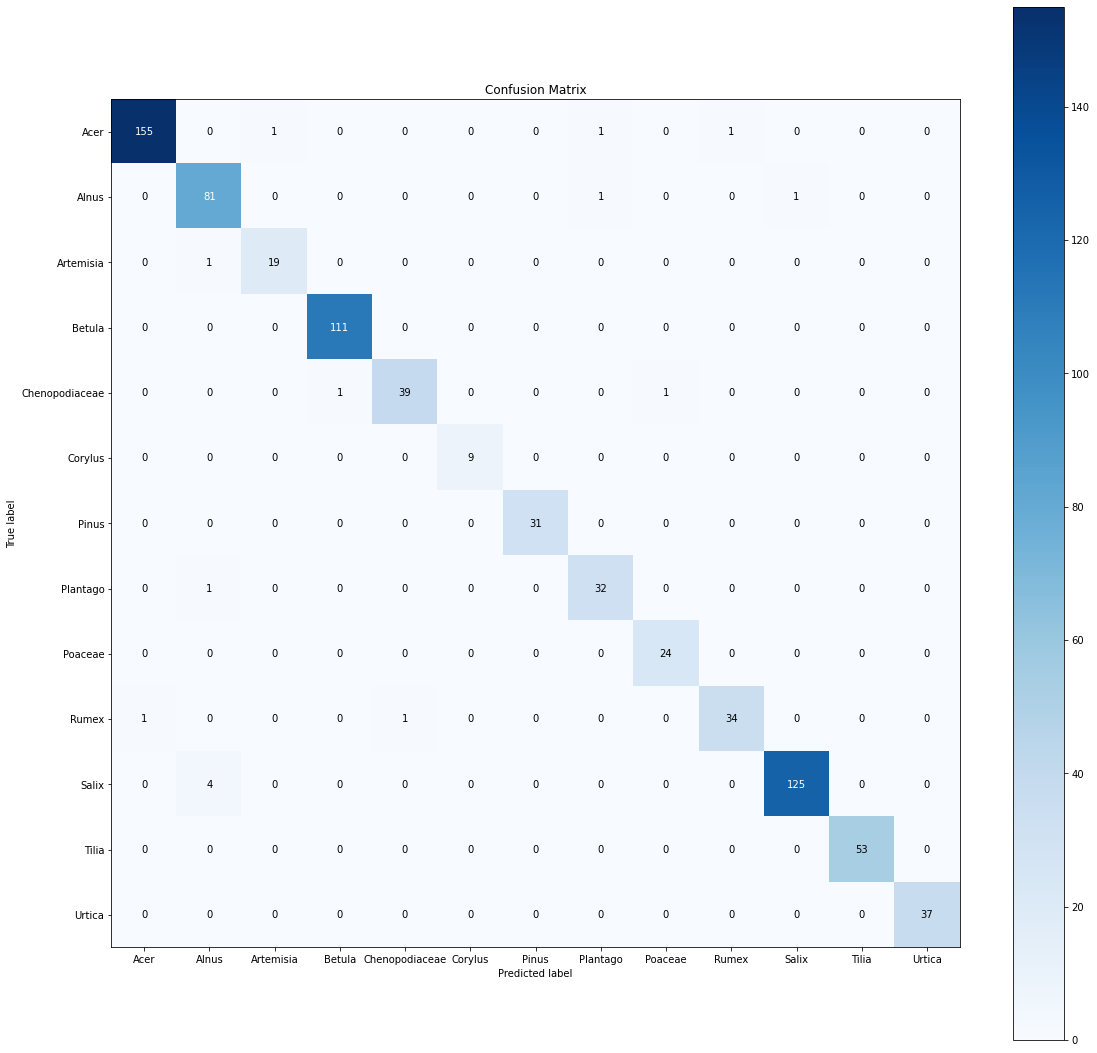

In [235]:
order = [5 ,
0 ,
6 ,
1 ,
8 ,
3 ,
9 ,
10 ,
2 ,
11 ,
12 ,
4 ,
7]
fig, ax = plt.subplots(figsize=(19,19))
plot_confusion_matrix(y_true, y_pred, labels=order, ax=ax)
ax.xaxis.set_ticklabels(sorted(labels)); ax.yaxis.set_ticklabels(sorted(labels));
fig.savefig('pic/conf_matrix.png', bbox_inches='tight', pad_inches=0)

In [9]:
suffix = '_sagan_65k_deep_'
stage = "pretrain"
# stage = "fine_tuning"
# stage = "transfer_learning"
batch_size = 64
nb_epoch = 350
learning_rate = 1e-2
optimizer =  Adam(lr=learning_rate)
data_augmentation = True
# number of convolutional filters to use at each layer
# nb_filters = [16, 32, 64]
nb_filters = [64, 64, 64, 64, 64, 64]
# level of pooling to perform at each layer (POOL x POOL)
nb_pool = [2, 2]
# level of convolution to perform at each layer (CONV x CONV)
nb_conv = [3, 3, 3, 3, 3, 3]
# input image dimensions
img_rows, img_cols = pollen.shape[1],pollen.shape[2]
print(img_rows,img_cols)
img_channels = 3
means_sc = []
means_ac = []
means_f1 = []
means_ac_val = []
means_f1_val = []


cv=0
kf = StratifiedKFold(n_splits=5)
# for train, test in kf.split(pollen, target):
for i in range(1):
#     print("!-----------------------"+str(cv+1)+"--------------------------!")

    datagen = ImageDataGenerator(
        featurewise_center=False,
        featurewise_std_normalization=False,
        rotation_range=180,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True)

    inputs = Input(shape=(img_rows, img_cols, img_channels))
    
    for i in range(5):
        if i==0:
            x = Convolution2D(nb_filters[i], (nb_conv[i], nb_conv[i]), padding='same')(inputs)
        else:
            x = Convolution2D(nb_filters[i], (nb_conv[i], nb_conv[i]), padding='same')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = AveragePooling2D(pool_size=(2, 2))(x)
        
    x = Flatten()(x)
    x = Dense(30)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(nb_classes)(x)
    outputs = Activation('softmax')(x)
    model = keras.Model(inputs, outputs)
    
    if stage == "fine_tuning":
        initial_learning_rate = 1e-3
    else:    
        initial_learning_rate = 1e-2    
#     decay_steps = 1000
    decay_steps = 50
    lr_decayed_fn = (tf.keras.experimental.CosineDecayRestarts(
                      initial_learning_rate,
                      decay_steps))
    optimizer =  Adam(lr=initial_learning_rate)
    
    if stage == "transfer_learning":
        model = load_model("CNN_cropped_pollen_pretrain"+suffix+".hdf5", compile=False)
    if stage == "fine_tuning":
        model = load_model("CNN_cropped_pollen_transfer_learning"+suffix+str(cv+1)+".hdf5", compile=False)    

    for i in [1,2,5,6,9,10,13,14,17,18,22,23]:
        model.layers[i].trainable = not (stage=="transfer_learning")
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy", 
                              tfa.metrics.F1Score(num_classes=nb_classes, average='macro')])
 

    X_train = pollen
    y_train = target
    Y_train = to_categorical(y_train, nb_classes)
#     print(Counter(y_train))
    checkpointer = ModelCheckpoint(filepath="CNN_cropped_pollen_"+stage+suffix+".hdf5", verbose=1, 
                                       save_best_only=True)
#     checkpointer = ModelCheckpoint(filepath="CNN_cropped_pollen_pretrain"+suffix+".hdf5", verbose=1, 
#                                        save_best_only=True)
    es = EarlyStopping(
            monitor    = 'loss',
            patience   = 20,
            mode       = 'min'
        )
#         rp = tf.keras.callbacks.ReduceLROnPlateau(
#                                                     monitor    = 'loss',
#                                                     factor     = 0.1,
#                                                     patience   = 4,
#                                                     verbose    = 1,
#                                                     mode       = 'auto',
#                                                     min_delta  = 0.0001,
#                                                     cooldown   = 0,
#                                                     min_lr     = 0
#                                                 )
    wandb.init(
      project="pollen-cnn",
      # Set entity to specify your username or team name
      # ex: entity="carey",
      config={
          "optimizer": "adam",
          "metric": ["accuracy","f1"],
          "epoch": nb_epoch,
          "batch_size": batch_size,
          "augmentation": "True",
          "intial_lr": initial_learning_rate,
          "weights": "CNN_cropped_pollen_"+stage+suffix+str(cv+1)+".hdf5",
          "lrscheduler":"CosineDecayRestarts"
      },
      tags=[suffix, stage+str(cv+1)], name='forth run')
    config = wandb.config   
    
    datagen.fit(X_train)
    model.fit_generator(datagen.flow(X_train, Y_train, batch_size=batch_size),
              steps_per_epoch=len(X_train) / batch_size, epochs=nb_epoch, 
              verbose=1, validation_data=(pollen_X_val, pollen_Y_val), 
              callbacks=[checkpointer, 
#                          es, 
                         LearningRateScheduler(lr_decayed_fn), 
                         WandbCallback()])
     
    model = load_model("CNN_cropped_pollen_"+stage+suffix+".hdf5", compile=False)
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=["accuracy", 
                          tfa.metrics.F1Score(num_classes=nb_classes, average='macro')])

    score = model.evaluate(pollen_X_val, pollen_Y_val, verbose=0)
    print('Val score:', score[0])
    print('Val accuracy:', score[1])        
    means_ac_val.append(score[1])
    means_f1_val.append(score[2])
                          
    wandb.finish()
    cv+=1          
    

print('Crossvalidate Val F1 score:',np.mean(means_f1_val))
print('Crossvalidate Val accuracy:',np.mean(means_ac_val))
with open('means'+suffix, 'w+') as thefile:
    for item in range(0,len(means_ac_val)):
        thefile.write("Val_F1-score=%0.4f Val_Acc=%f\n"  %(means_f1_val[item], means_ac_val[item])) 
    thefile.write("Val_Mean_F1-score=%0.4f Val_Mean_Acc=%f\n"  %(np.mean(means_f1_val), np.mean(means_ac_val)))          

32 32


wandb: Currently logged in as: natkaha (use `wandb login --relogin` to force relogin)
wandb: wandb version 0.12.2 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
Train for 1015.625 steps, validate on 765 samples
Epoch 1/350
1014/1015 [============================>.] - ETA: 0s - loss: 1.0993 - accuracy: 0.6245 - f1_score: 0.6190
Epoch 00001: val_loss improved from inf to 2.21249, saving model to CNN_cropped_pollen_pretrain_sagan_65k_deep_.hdf5
1016/1015 [==============================] - 35s 34ms/step - loss: 1.0991 - accuracy: 0.6246 - f1_score: 0.6191 - val_loss: 2.2125 - val_accuracy: 0.5033 - val_f1_score: 0.4482
Epoch 2/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.7990 - accuracy: 0.7433 - f1_score: 0.7425
Epoch 00002: val_loss did not improve from 2.21249
1016/1015 [==============================] - 32s 32ms/step - loss: 0.7989 - accuracy: 0.7434 - f1_score: 0.7426 - val_loss: 2.3114 - val_accuracy: 0.5516 - val_f1_score: 0.4092
Epoch 3/350
1012/1015 [============================>.] - ETA: 0s - loss: 0.7016 - accuracy:

1014/1015 [============================>.] - ETA: 0s - loss: 0.2091 - accuracy: 0.9344 - f1_score: 0.9344- ETA: 7s - loss: 0.2089 - accuracy: 0.934 - ETA: 5s - loss: 0.2084 - accurac
Epoch 00040: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.2090 - accuracy: 0.9345 - f1_score: 0.9344 - val_loss: 5.2078 - val_accuracy: 0.5438 - val_f1_score: 0.5124
Epoch 41/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.2128 - accuracy: 0.9340 - f1_score: 0.9339  ETA: 10s - loss: 0. - ETA: 3s - loss: 0.2118 - accuracy: 0.9343 - f1_scor - ETA: 3s - los
Epoch 00041: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.2127 - accuracy: 0.9340 - f1_score: 0.9339 - val_loss: 5.2413 - val_accuracy: 0.5386 - val_f1_score: 0.4833
Epoch 42/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.2049 - accuracy: 0.9365 - f1_score: 0.9364
Epoch 00042: val_loss did not im

1015/1015 [============================>.] - ETA: 0s - loss: 0.2373 - accuracy: 0.9272 - f1_score: 0.9272
Epoch 00080: val_loss did not improve from 1.79928
1016/1015 [==============================] - 30s 30ms/step - loss: 0.2373 - accuracy: 0.9272 - f1_score: 0.9272 - val_loss: 5.2271 - val_accuracy: 0.5425 - val_f1_score: 0.5120
Epoch 81/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.2323 - accuracy: 0.9280 - f1_score: 0.9280- ETA: - ETA: 4s - loss: 0.2320 - accuracy: 0.9283 - f1_score: - ETA: 3s - loss: 0.23 - ETA: 1s - loss: 0.2328 - accuracy: 0.
Epoch 00081: val_loss did not improve from 1.79928
1016/1015 [==============================] - 31s 30ms/step - loss: 0.2323 - accuracy: 0.9280 - f1_score: 0.9280 - val_loss: 7.4308 - val_accuracy: 0.5033 - val_f1_score: 0.3814
Epoch 82/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.2344 - accuracy: 0.9273 - f1_score: 0.9272- ETA: 2s - los
Epoch 00082: val_loss did not improve from 1.79928
1016/1015

Epoch 103/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.1836 - accuracy: 0.9432 - f1_score: 0.9432
Epoch 00103: val_loss did not improve from 1.79928
1016/1015 [==============================] - 30s 29ms/step - loss: 0.1837 - accuracy: 0.9432 - f1_score: 0.9432 - val_loss: 8.7701 - val_accuracy: 0.4758 - val_f1_score: 0.4661
Epoch 104/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1838 - accuracy: 0.9431 - f1_score: 0.9430
Epoch 00104: val_loss did not improve from 1.79928
1016/1015 [==============================] - 30s 30ms/step - loss: 0.1837 - accuracy: 0.9431 - f1_score: 0.9431 - val_loss: 7.7283 - val_accuracy: 0.5216 - val_f1_score: 0.4590
Epoch 105/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1834 - accuracy: 0.9430 - f1_score: 0.9430
Epoch 00105: val_loss did not improve from 1.79928
1016/1015 [==============================] - 30s 30ms/step - loss: 0.1834 - accuracy: 0.9430 - f1_score: 0.9429 - val_loss: 6.0537 - 

Epoch 125/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.1466 - accuracy: 0.9537 - f1_score: 0.9537  ETA: 10s - loss: 0.1489 - accur  - ETA: - ETA: 1s - loss: 0.1475 - accuracy: 0.9536
Epoch 00125: val_loss did not improve from 1.79928
1016/1015 [==============================] - 31s 31ms/step - loss: 0.1466 - accuracy: 0.9537 - f1_score: 0.9537 - val_loss: 8.8825 - val_accuracy: 0.5386 - val_f1_score: 0.5033
Epoch 126/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9545 - f1_score: 0.9546
Epoch 00126: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.1470 - accuracy: 0.9546 - f1_score: 0.9546 - val_loss: 9.8215 - val_accuracy: 0.5085 - val_f1_score: 0.4824
Epoch 127/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1431 - accuracy: 0.9555 - f1_score: 0.9555- ETA: 1s - loss: 0.1429 - accuracy: 0.9556 -  - ETA: 0s - loss: 0.1429 - accuracy: 0.9555 - f1_scor

1014/1015 [============================>.] - ETA: 0s - loss: 0.2173 - accuracy: 0.9315 - f1_score: 0.9315
Epoch 00165: val_loss did not improve from 1.79928
1016/1015 [==============================] - 31s 31ms/step - loss: 0.2176 - accuracy: 0.9314 - f1_score: 0.9314 - val_loss: 5.5498 - val_accuracy: 0.5830 - val_f1_score: 0.5306
Epoch 166/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.2139 - accuracy: 0.9340 - f1_score: 0.9341
Epoch 00166: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 31ms/step - loss: 0.2139 - accuracy: 0.9340 - f1_score: 0.9341 - val_loss: 5.4657 - val_accuracy: 0.5660 - val_f1_score: 0.5375
Epoch 167/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.2111 - accuracy: 0.9338 - f1_score: 0.9338
Epoch 00167: val_loss did not improve from 1.79928
1016/1015 [==============================] - 31s 31ms/step - loss: 0.2113 - accuracy: 0.9337 - f1_score: 0.9337 - val_loss: 4.7724 - val_accuracy: 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1014/1015 [============================>.] - ETA: 0s - loss: 0.1773 - accuracy: 0.9451 - f1_score: 0.9451
Epoch 00200: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.1774 - accuracy: 0.9451 - f1_score: 0.9451 - val_loss: 8.5813 - val_accuracy: 0.5085 - val_f1_score: 0.4721
Epoch 201/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.1882 - accuracy: 0.9423 - f1_score: 0.9423
Epoch 00201: val_loss did not improve from 1.79928
1016/1015 [==============================] - 33s 32ms/step - loss: 0.1882 - accuracy: 0.9423 - f1_score: 0.9423 - val_loss: 7.8362 - val_accuracy: 0.5111 - val_f1_score: 0.4485
Epoch 202/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.1805 - accuracy: 0.9432 - f1_score: 0.9432- ETA: 2s - loss: 0.1805 -
Epoch 00202: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.1805 - accuracy: 0.9432 - f1_score: 0.9432 - val_los

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1014/1015 [============================>.] - ETA: 0s - loss: 0.1680 - accuracy: 0.9473 - f1_score: 0.9473- ETA: 6s - loss: 0
Epoch 00220: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.1679 - accuracy: 0.9473 - f1_score: 0.9473 - val_loss: 6.5590 - val_accuracy: 0.5739 - val_f1_score: 0.5142
Epoch 221/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1672 - accuracy: 0.9482 - f1_score: 0.9483- ETA: 2s - loss: 0.1671 - accura - ETA: 0s - loss: 0.1671 - accuracy: 0.9482 - f1_score: 0
Epoch 00221: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.1672 - accuracy: 0.9482 - f1_score: 0.9482 - val_loss: 8.5113 - val_accuracy: 0.5242 - val_f1_score: 0.4983
Epoch 222/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1660 - accuracy: 0.9493 - f1_score: 0.9493- ETA: 3s 
Epoch 00222: val_loss did not improve from 1.79928
1016/1015 [================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1014/1015 [============================>.] - ETA: 0s - loss: 0.1460 - accuracy: 0.9545 - f1_score: 0.9545- ETA: 4s - loss: - ETA: 1s - loss: 0.1460 - accuracy: 
Epoch 00241: val_loss did not improve from 1.79928
1016/1015 [==============================] - 31s 31ms/step - loss: 0.1460 - accuracy: 0.9545 - f1_score: 0.9545 - val_loss: 9.8655 - val_accuracy: 0.5281 - val_f1_score: 0.4937
Epoch 242/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.1470 - accuracy: 0.9539 - f1_score: 0.9539
Epoch 00242: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 31ms/step - loss: 0.1473 - accuracy: 0.9539 - f1_score: 0.9539 - val_loss: 7.3696 - val_accuracy: 0.5974 - val_f1_score: 0.5520
Epoch 243/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.1532 - accuracy: 0.9521 - f1_score: 0.9521
Epoch 00243: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 31ms/step - loss: 0.1531 - accuracy: 0.9521

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1014/1015 [============================>.] - ETA: 0s - loss: 0.1323 - accuracy: 0.9577 - f1_score: 0.9578- ETA: 4s - loss: 0.1308 - accuracy: 0.9582 - f1_score: 0. - ET
Epoch 00261: val_loss did not improve from 1.79928
1016/1015 [==============================] - 33s 32ms/step - loss: 0.1324 - accuracy: 0.9577 - f1_score: 0.9577 - val_loss: 9.6907 - val_accuracy: 0.5359 - val_f1_score: 0.4961
Epoch 262/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1312 - accuracy: 0.9581 - f1_score: 0.9581
Epoch 00262: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.1312 - accuracy: 0.9582 - f1_score: 0.9581 - val_loss: 8.0627 - val_accuracy: 0.5712 - val_f1_score: 0.5253
Epoch 263/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9580 - f1_score: 0.9580
Epoch 00263: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.1345 - accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1015/1015 [============================>.] - ETA: 0s - loss: 0.1208 - accuracy: 0.9614 - f1_score: 0.9614
Epoch 00281: val_loss did not improve from 1.79928
1016/1015 [==============================] - 31s 31ms/step - loss: 0.1207 - accuracy: 0.9614 - f1_score: 0.9614 - val_loss: 9.7440 - val_accuracy: 0.5582 - val_f1_score: 0.5116
Epoch 282/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1172 - accuracy: 0.9625 - f1_score: 0.9625
Epoch 00282: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.1171 - accuracy: 0.9625 - f1_score: 0.9625 - val_loss: 15.3557 - val_accuracy: 0.4954 - val_f1_score: 0.4402
Epoch 283/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1198 - accuracy: 0.9629 - f1_score: 0.9629
Epoch 00283: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 31ms/step - loss: 0.1198 - accuracy: 0.9630 - f1_score: 0.9630 - val_loss: 11.4399 - val_accuracy

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1014/1015 [============================>.] - ETA: 0s - loss: 0.1075 - accuracy: 0.9660 - f1_score: 0.9660
Epoch 00301: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.1075 - accuracy: 0.9660 - f1_score: 0.9660 - val_loss: 15.5640 - val_accuracy: 0.5033 - val_f1_score: 0.4612
Epoch 302/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1083 - accuracy: 0.9659 - f1_score: 0.9659- ETA: 
Epoch 00302: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 32ms/step - loss: 0.1083 - accuracy: 0.9659 - f1_score: 0.9659 - val_loss: 13.2398 - val_accuracy: 0.5281 - val_f1_score: 0.4744
Epoch 303/350
1015/1015 [============================>.] - ETA: 0s - loss: 0.1070 - accuracy: 0.9654 - f1_score: 0.9654
Epoch 00303: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 31ms/step - loss: 0.1071 - accuracy: 0.9653 - f1_score: 0.9653 - val_loss: 15.0424 - val_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1014/1015 [============================>.] - ETA: 0s - loss: 0.0997 - accuracy: 0.9677 - f1_score: 0.9677- ETA: 0s - loss: 0.0996 - accuracy: 0.9678 - f1_score: 
Epoch 00322: val_loss did not improve from 1.79928
1016/1015 [==============================] - 31s 30ms/step - loss: 0.0996 - accuracy: 0.9677 - f1_score: 0.9677 - val_loss: 15.4711 - val_accuracy: 0.5150 - val_f1_score: 0.4736
Epoch 323/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.1003 - accuracy: 0.9677 - f1_score: 0.9677  ETA: 10s - loss: 0.1008 - accuracy: 0.9674 - f1_score: 0.96 - ETA: 10s - loss: 0.1
Epoch 00323: val_loss did not improve from 1.79928
1016/1015 [==============================] - 31s 31ms/step - loss: 0.1002 - accuracy: 0.9677 - f1_score: 0.9677 - val_loss: 14.3694 - val_accuracy: 0.5242 - val_f1_score: 0.4854
Epoch 324/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.0996 - accuracy: 0.9675 - f1_score: 0.9675- ETA: 1s - loss: 0.1001 - accuracy: 0.967
Epoch 00324: v

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1015/1015 [============================>.] - ETA: 0s - loss: 0.0953 - accuracy: 0.9696 - f1_score: 0.9696
Epoch 00341: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 31ms/step - loss: 0.0953 - accuracy: 0.9696 - f1_score: 0.9696 - val_loss: 16.0268 - val_accuracy: 0.5098 - val_f1_score: 0.4598
Epoch 342/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.0989 - accuracy: 0.9689 - f1_score: 0.9689
Epoch 00342: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 31ms/step - loss: 0.0990 - accuracy: 0.9689 - f1_score: 0.9689 - val_loss: 15.7826 - val_accuracy: 0.5163 - val_f1_score: 0.4723
Epoch 343/350
1014/1015 [============================>.] - ETA: 0s - loss: 0.0969 - accuracy: 0.9685 - f1_score: 0.9685
Epoch 00343: val_loss did not improve from 1.79928
1016/1015 [==============================] - 32s 31ms/step - loss: 0.0971 - accuracy: 0.9684 - f1_score: 0.9684 - val_loss: 16.0296 - val_accurac

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [21]:
! conda list tensorflow

# packages in environment at /mnt/tank/scratch/nkhanzhina/miniconda3/envs/env-tf23:
#
# Name                    Version                   Build  Channel
tensorflow                2.3.0                    pypi_0    pypi
tensorflow-addons         0.13.0                   pypi_0    pypi
tensorflow-base           2.1.0           gpu_py37h6c5654b_0  
tensorflow-estimator      2.5.0                    pypi_0    pypi
tensorflow-gpu            2.1.0                h0d30ee6_0  
tensorflow-gpu-estimator  2.1.0                    pypi_0    pypi


In [ ]:
! pip uninstall tensorflow-addons

In [ ]:
! pip uninstall tensorflow-addons

wandb.finish()

In [21]:
model.layers[13]

In [20]:
! tail means_baseline_

F1-score=0.7028 Acc=0.746224
F1-score=0.7863 Acc=0.787009
F1-score=0.7611 Acc=0.794562
Mean_F1-score=0.7353 Mean_Acc=0.769330
Val_F1-score=0.9304 Val_Acc=0.951634
Val_F1-score=0.4900 Val_Acc=0.627451
Val_F1-score=0.6937 Val_Acc=0.780392
Val_F1-score=0.7421 Val_Acc=0.809150
Val_F1-score=0.7321 Val_Acc=0.820915
Val_Mean_F1-score=0.7177 Val_Mean_Acc=0.797908


In [34]:
! tail means_sagan_65k_

F1-score=0.9640 Acc=0.965257
F1-score=0.9560 Acc=0.962236
F1-score=0.9648 Acc=0.969788
Mean_F1-score=0.9556 Mean_Acc=0.960150
Val_F1-score=0.9254 Val_Acc=0.945098
Val_F1-score=0.9336 Val_Acc=0.954248
Val_F1-score=0.9497 Val_Acc=0.960784
Val_F1-score=0.9295 Val_Acc=0.945098
Val_F1-score=0.9298 Val_Acc=0.949020
Val_Mean_F1-score=0.9336 Val_Mean_Acc=0.950850


In [25]:
! tail means_stylegan_65k_

F1-score=0.9821 Acc=0.980363
F1-score=0.9757 Acc=0.977341
F1-score=0.9778 Acc=0.978852
Mean_F1-score=0.9751 Mean_Acc=0.974642
Val_F1-score=0.9677 Val_Acc=0.971242
Val_F1-score=0.9668 Val_Acc=0.968627
Val_F1-score=0.9727 Val_Acc=0.972549
Val_F1-score=0.9781 Val_Acc=0.975163
Val_F1-score=0.9725 Val_Acc=0.973856
Val_Mean_F1-score=0.9716 Val_Mean_Acc=0.972288


In [95]:
! rm means

In [178]:
! mv meansstylegan means_stylegan

In [96]:
with open('means', 'w+') as thefile:
    for item in range(0,len(means_sc)):
#         thefile.write("Loss=%0.4f Acc=%f\n"  %((means_sc[item]), (means_ac[item])))
        thefile.write("F1-score=%0.4f Acc=%f\n"  %(means_f1[item], means_ac[item]))  
    thefile.write("Mean_F1-score=%0.4f Mean_Acc=%f\n"  %(np.mean(means_f1), np.mean(means_ac)))  